In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay

import shap
import lime
import lime.lime_tabular
from lime import submodular_pick

from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer, accuracy_score
import operator

import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("../data/train_simple.gzip", compression="gzip")
dataset.shape

(279792, 23)

In [3]:
cat_cols = ["region", "osm_city_nearest_name", "realty_type"]

for col in cat_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

In [4]:
dataset["floor"] = dataset["floor"].fillna(1)
dataset["city_population"] = dataset["city_population"].fillna(0)

In [5]:
dataset["price_type"] = dataset["price_type"].astype(bool)

In [6]:
dataset.isna().sum().sum()

0

# Split data

In [7]:
target = "per_square_meter_price"
treatment = "price_type"

In [8]:
feature_columns = [
    'city_population',                  # население города
    'total_square',                     # Общая площадь
    'osm_catering_points_in_0.005',     # Кол-во заведений общепита в радиусе 500 метров, OpenStreetMap
    'region',                           # Регион
    'floor',                            # Этаж
    'realty_type',                      # Тип недвижимости (закодирован)
    'osm_crossing_closest_dist',        # Расстояние до ближайшего пешеходного перехода
    'osm_city_nearest_name',            # Название ближайшего города по OpenStreetMap
    'osm_subway_closest_dist',          # Расстояние до ближайщей станции метро, OpenStreetMap
    'reform_mean_floor_count_1000',     # Средняя этажность домов в радиусе 1 км по истоинчку РеформаЖКХ
    'osm_transport_stop_closest_dist',  # Расстояние до ближайщей остановки общественного транспорта, OpenStreetMap
    'osm_amenity_points_in_0.001',      # Кол-во объектов связанных с удобством в радиусе 100 метров, OpenStreetMap
    'osm_city_nearest_population',      # Население ближайшего города по OpenStreetMap
    'lng',                              # Долгота
    'osm_city_closest_dist',            # Расстояние до центра ближайшего города, OpenStreetMap
    'osm_crossing_points_in_0.005',     # Кол-во пешеходных переходов в радиусе 500 метров, OpenStreetMap
    'floor_type',                       # тип этажа
    'lat',                              # Широта
    'reform_mean_year_building_500',    # Среднее значение года постройки домов в радиусе 500 метров по истоинчку РеформаЖКХ
    'osm_culture_points_in_0.005',      # Кол-во объектов культуры в радиусе 500 метров, OpenStreetMap
    'reform_house_population_500',      # Коэффициент количества проживающих людей в радиусе 500 метров по источнику РеформаЖКХ
]

In [9]:
X_train = dataset.loc[dataset[treatment] == 0, feature_columns]
X_test = dataset.loc[dataset[treatment] == 1, feature_columns]

y_train = dataset.loc[dataset[treatment] == 0, target]
y_test = dataset.loc[dataset[treatment] == 1, target]

X_train.shape, X_test.shape

((275299, 21), (4493, 21))

In [31]:
y_test.describe().apply("{0:.5f}".format)

count       4493.00000
mean       69158.61151
std        89417.50418
min         1095.94318
25%        37808.08881
50%        49754.14296
75%        68755.07138
max      1790992.61276
Name: per_square_meter_price, dtype: object

In [32]:
y_train.describe().apply("{0:.5f}".format)

count     275299.00000
mean      110865.20885
std       172991.67377
min          389.61039
25%        29383.62430
50%        60172.78618
75%       119401.03974
max      1990000.00000
Name: per_square_meter_price, dtype: object

# Model

## Regression problem

In [15]:
%%time

model = CatBoostRegressor(loss_function='RMSE', verbose=0)
model = model.fit(X_train, y_train)

CPU times: user 1min 56s, sys: 3.49 s, total: 1min 59s
Wall time: 17.3 s


# Log target

In [12]:
def log_rmse(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

lrmse_scorer = make_scorer(log_rmse, greater_is_better=False)

In [13]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

### KNN result

In [22]:
%%time

model.fit(
    X_train.iloc[:, :16], 
    y_train_log,
)
y_pred = model.predict(X_test.iloc[:, :16])
log_rmse(y_test_log, y_pred)

CPU times: user 1min 15s, sys: 663 ms, total: 1min 16s
Wall time: 11.6 s


87409.77669857044

### CatBoost result

In [16]:
%%time

model.fit(
    X_train.iloc[:, :16], 
    y_train_log,
)
y_pred = model.predict(X_test.iloc[:, :16])
log_rmse(y_test_log, y_pred)

CPU times: user 1min 33s, sys: 2.85 s, total: 1min 36s
Wall time: 15.6 s


77556.51241913968

## Classification problem

In [37]:
y_train.median()

60172.78617710584

In [38]:
y_test.median()

49754.14296267123

In [240]:
dataset["Income"] = (dataset[target] >= 50000).astype(int)

In [39]:
y_train_class = (y_train >= 50000).astype(int)
y_test_class = (y_test >= 50000).astype(int)

In [42]:
%%time

model_class = CatBoostClassifier(verbose=0, random_seed=1337)
model_class = model_class.fit(X_train, y_train_class)

CPU times: user 2min 31s, sys: 6.94 s, total: 2min 38s
Wall time: 24.6 s


In [46]:
accuracy_score(y_test_class, model_class.predict(X_test))

0.730469619407968

### Make another train/test split

In [9]:
dataset["Income"] = (dataset[target] >= 50000).astype(int)

In [10]:
labels = dataset["Income"]
le= LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_

In [11]:
dataset.drop(['per_square_meter_price', 'Income'], axis=1, inplace=True)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279792 entries, 0 to 279791
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   city_population                  279792 non-null  float64
 1   total_square                     279792 non-null  float64
 2   osm_catering_points_in_0.005     279792 non-null  int64  
 3   region                           279792 non-null  int64  
 4   floor                            279792 non-null  float64
 5   realty_type                      279792 non-null  int64  
 6   osm_crossing_closest_dist        279792 non-null  float64
 7   osm_city_nearest_name            279792 non-null  int64  
 8   osm_subway_closest_dist          279792 non-null  float64
 9   reform_mean_floor_count_1000     279792 non-null  float64
 10  osm_transport_stop_closest_dist  279792 non-null  float64
 11  osm_amenity_points_in_0.001      279792 non-null  int64  
 12  os

In [13]:
categorical_features = ['region','realty_type', 'osm_city_nearest_name', 'floor_type', 'price_type']
categorical_features_indices = [3,5,7,16,21]

In [14]:
categorical_names = {}
for feature in categorical_features_indices:
    print(feature)
    le = LabelEncoder()
    le.fit(dataset.iloc[:, feature])
    dataset.iloc[:, feature] = le.transform(dataset.iloc[:, feature])
    categorical_names[feature] = le.classes_

3
5
7
16
21


In [15]:
datasetf = dataset.astype(float)

In [16]:
datasetf

city_population  total_square  osm_catering_points_in_0.005  region  \
0             1048011.0     32.000000                           2.0    31.0   
1               32885.0    280.000000                           2.0    25.0   
2              604128.0    297.400000                           3.0    48.0   
3              551919.0    190.000000                           0.0    14.0   
4            12380691.0     60.200000                           8.0    24.0   
...                 ...           ...                           ...     ...   
279787         575352.0    358.320073                           9.0    41.0   
279788        5225690.0    119.637556                          96.0    35.0   
279789         467289.0    312.789725                           2.0    11.0   
279790         558973.0     89.201305                          16.0    14.0   
279791         532429.0    172.855871                           1.0    15.0   

        floor  realty_type  osm_crossing_closest_dist  osm_city_nearest_name  \
0         1.0          0.0                   0.027732                  109.0   
1         1.0          0.0                   0.089441                  104.0   
2         1.0          2.0                   0.200995                  167.0   
3         1.0          2.0                   0.861400                   89.0   
4         1.0          0.0                   0.236744                  156.0   
...       ...          ...                        ...                    ...   
279787    1.0          0.0                   0.116917                  147.0   
279788    1.0          2.0                   0.110570                  125.0   
279789    3.0          0.0                   0.108723                   48.0   
279790    1.0          2.0                   0.341931                   52.0   
279791    1.0          2.0                   0.126115                   54.0   

        osm_subway_closest_dist  reform_mean_floor_count_1000  ...  \
0                    269.024986                      5.762963  ...   
1                    102.455451                      2.894366  ...   
2                    243.361937                      6.141414  ...   
3                    295.633502                      8.581081  ...   
4                      1.110429                      7.263889  ...   
...                         ...                           ...  ...   
279787               201.668316                      5.714286  ...   
279788                 0.748926                      4.719388  ...   
279789               814.733428                      3.950413  ...   
279790               200.109079                      4.691489  ...   
279791               306.460323                      5.069124  ...   

        osm_city_nearest_population        lng  osm_city_closest_dist  \
0                         1055397.0  56.292797               3.293470   
1                          120184.0  39.543835              43.950989   
2                          603961.0  39.850525               2.676293   
3                          552105.0  87.108604              15.618563   
4                          232066.0  37.487110               9.995325   
...                             ...        ...                    ...   
279787                     576624.0  84.979334               3.614641   
279788                    5381736.0  30.356383               2.063594   
279789                     453461.0  20.514968               2.126417   
279790                     558662.0  86.081460               0.844577   
279791                     496986.0  49.677439               1.317512   

        osm_crossing_points_in_0.005  floor_type        lat  \
0                                6.0         0.0  57.998207   
1                               31.0         0.0  55.574284   
2                               15.0         0.0  57.619140   
3                                0.0         0.0  53.897083   
4                               14.0         0.0  55.802590   
..

In [17]:
encoder = ColumnTransformer([("enc", sklearn.preprocessing.OneHotEncoder(), categorical_features_indices)], remainder = 'passthrough')

In [18]:
np.random.seed(1)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(datasetf, labels, train_size=0.8)

In [19]:
encoder.fit(datasetf)
encoded_train = encoder.transform(train)

In [20]:
%%time

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(encoded_train, labels_train)
accuracy_score(labels_test, rf.predict(encoder.transform(test)))

CPU times: user 21min 17s, sys: 1.45 s, total: 21min 18s
Wall time: 2min 53s


0.881877803391769

In [21]:
%%time

cf = CatBoostClassifier(verbose=0, random_seed=1337,thread_count=-1)
cf.fit(encoded_train, labels_train)
accuracy_score(labels_test, cf.predict(encoder.transform(test)))

CPU times: user 1min 53s, sys: 5.11 s, total: 1min 59s
Wall time: 18.1 s


0.8354509551636019

# Feature importance

### Regression analysis

#### Feature importance from CatBoost package

In [37]:
cf.get_feature_importance(prettified=True)

Feature Id  Importances
0          227    13.080390
1          236    10.609902
2          231     9.184406
3          237     5.835080
4          232     5.660673
..         ...          ...
238        207     0.000000
239        209     0.000000
240        213     0.000000
241        217     0.000000
242        221     0.000000

[243 rows x 2 columns]

In [23]:
import shap
from catboost import Pool

In [24]:
shap.initjs()

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train))

In [20]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

In [22]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[0:500,:], X_train.iloc[0:500,:])

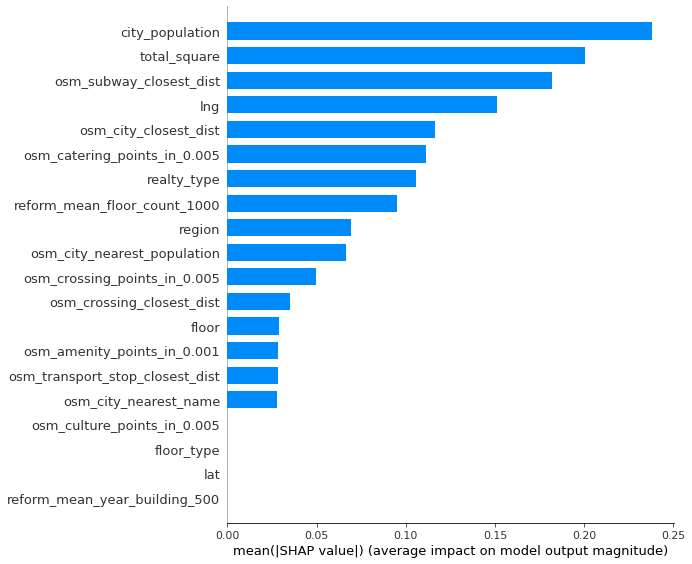

In [23]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

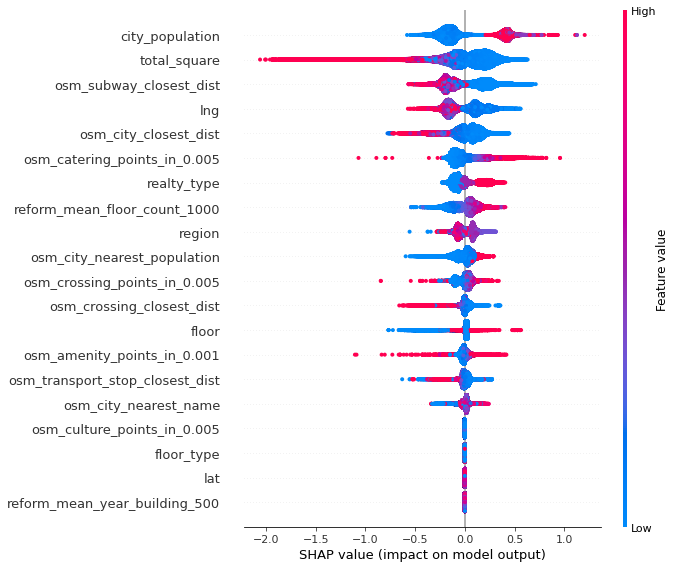

In [24]:
shap.summary_plot(shap_values, X_train)

### For regression train/test split and problem

In [48]:
predict_fn = lambda x: model_class.predict_proba(x).astype(float)

In [102]:
class0 = predict_fn(X_test)[:,0][y_test_class==0]
false_0 = (X_test[y_test_class==0].reset_index()).loc[np.argmin(class0)] #1791
true_0 = (X_test[y_test_class==0].reset_index()).loc[np.argmax(class0)] #661


class1 = predict_fn(X_test)[:,0][y_test_class==1]
false_1 = (X_test[y_test_class==1].reset_index()).loc[np.argmin(class1)] #212
true_1 = (X_test[y_test_class==1].reset_index()).loc[np.argmax(class1)] #1881

### For classifying train/test split and problem

In [26]:
predict_fn = lambda x: rf.predict_proba(encoder.transform(x)).astype(float)

In [27]:
class0 = predict_fn(test)[:,0][labels_test==0]
false_0 = (test[labels_test==0].reset_index()).loc[np.argmin(class0)] #593
true_0 = (test[labels_test==0].reset_index()).loc[np.argmax(class0)] #9


class1 = predict_fn(test)[:,1][labels_test==1]
false_1 = (test[labels_test==1].reset_index()).loc[np.argmin(class1)] #1606
true_1 = (test[labels_test==1].reset_index()).loc[np.argmax(class1)] #3

# Lime

Теперь попробуем просмотреть аналогичные примеры для Lime

In [27]:
feature_names = dataset.columns

In [58]:
explainer = lime.lime_tabular.LimeTabularExplainer(train.values[:,:],feature_names=feature_names,class_names=class_names,
                                                   categorical_features=categorical_features_indices, 
                                                   categorical_names=categorical_names)

In [59]:
n_explanations = 8

In [60]:
exp = explainer.explain_instance(true_0.iloc[1:], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but OneHotEncoder was fitted with feature names


In [61]:
exp = explainer.explain_instance(false_0.iloc[1:], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but OneHotEncoder was fitted with feature names


In [62]:
exp = explainer.explain_instance(true_1.iloc[1:], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but OneHotEncoder was fitted with feature names


In [63]:
exp = explainer.explain_instance(false_1.iloc[1:], predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but OneHotEncoder was fitted with feature names


### SHAP

In [28]:
nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), 
                   random_state=0)
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, 
                                 min_samples_split=2, random_state=0, n_jobs=-1)
dtree = sklearn.tree.DecisionTreeClassifier(min_samples_split=2)

ctb_clf = CatBoostClassifier(verbose=0, random_seed=1337, thread_count=-1)

classifiers = [("Neural networks", nn), ("Random forests", rforest), ("Decision tree",dtree), ("CatBoost", ctb_clf)]

In [29]:
print("Model accuracies")
for name, clf in classifiers:
  clf.fit(train, labels_train)
  print("{1:20s} {0:.2f}".format(accuracy_score(labels_test, clf.predict(test)),name))

Model accuracies
Neural networks      0.57
Random forests       0.89
Decision tree        0.85
CatBoost             0.84


In [31]:
false_0_id = np.where((test == false_0[1:]).sum(axis=1) == 22)[0][0]
true_0_id = np.where((test == true_0[1:]).sum(axis=1) == 22)[0][0]
false_1_id = np.where((test == false_1[1:]).sum(axis=1) == 22)[0][0]
true_1_id = np.where((test == true_1[1:]).sum(axis=1) == 22)[0][0]
print(f"false0:{false_0_id}\n true0:{true_0_id} \n false1:{false_1_id} \n true1:{true_1_id}")

false0:1423
 true0:31 
 false1:2757 
 true1:3


In [32]:
list_in = [1423, 31, 2757, 3]
labels_train[list_in]

array([0, 0, 1, 1])

In [33]:
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(test.iloc[[1423, 31, 2757, 3],:])

In [38]:
feature_names = dataset.columns

In [35]:
shap.initjs()

In [54]:
rid, pid = (0, 1423)
pred_label = rforest.predict(test.iloc[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, rforest.predict_proba(test.iloc[[pid],:])[0][pred_label]))
shap.force_plot(explainer.expected_value[0], shap_values[0][0], test.iloc[pid,:], feature_names=feature_names)

True class 0, predicted one is 1 (with P = 1.00)


In [53]:
rid, pid = (1, 31)
pred_label = rforest.predict(test.iloc[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, rforest.predict_proba(test.iloc[[pid],:])[0][pred_label]))
shap.force_plot(explainer.expected_value[0], shap_values[0][1], test.iloc[pid,:], feature_names=feature_names)

True class 0, predicted one is 0 (with P = 1.00)


In [56]:
rid, pid = (2, 2757)
pred_label = rforest.predict(test.iloc[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, rforest.predict_proba(test.iloc[[pid],:])[0][pred_label]))
shap.force_plot(explainer.expected_value[0], shap_values[0][2], test.iloc[pid,:], feature_names=feature_names)

True class 1, predicted one is 0 (with P = 0.98)


In [57]:
rid, pid = (3, 3)
pred_label = rforest.predict(test.iloc[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, rforest.predict_proba(test.iloc[[pid],:])[0][pred_label]))
shap.force_plot(explainer.expected_value[0], shap_values[0][3], test.iloc[pid,:], feature_names=feature_names)

True class 1, predicted one is 1 (with P = 1.00)


In [ ]:
exp_array =  shap.sample(test, 100)
shap_values = explainer.shap_values(exp_array)
shap.force_plot(explainer.expected_value, shap_values[0], exp_array, feature_names=feature_names)

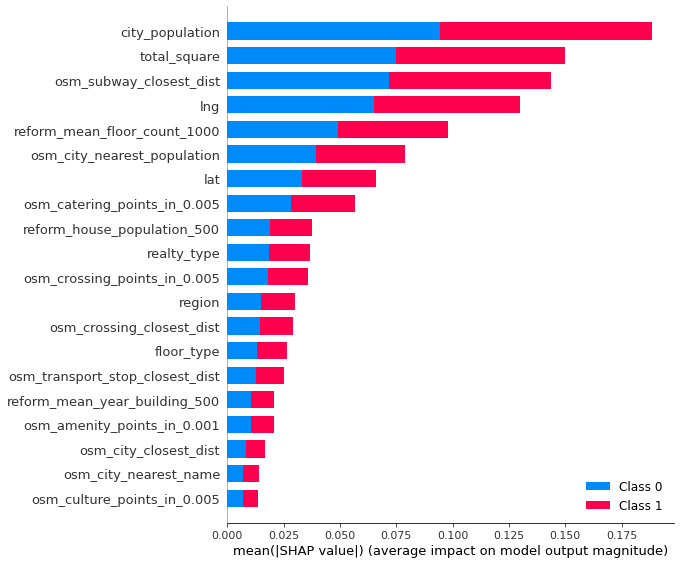

In [104]:
shap.summary_plot(shap_values, train, plot_type="bar")